In [5]:
! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 25.0 MB/s 
     |████████████████████████████████| 365 kB 52.0 MB/s 
     |████████████████████████████████| 6.6 MB 44.4 MB/s 
     |████████████████████████████████| 120 kB 61.4 MB/s 
     |████████████████████████████████| 212 kB 55.6 MB/s 
     |████████████████████████████████| 115 kB 51.9 MB/s 
     |████████████████████████████████| 127 kB 52.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Import packages


In [6]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,DefaultDataCollator
from datasets import load_dataset
import re
import tensorflow as tf
from tensorflow import keras
import datetime
import matplotlib.pyplot as plt



Assign distlbert checkpoint

In [30]:
checkpoint="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(checkpoint)



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
input_file_path= "/content/drive/MyDrive/Colab Notebooks/training_140_sentiment.csv"

Read from input file

In [33]:
sentiment_colls=['sentiment','tweet_id','tweet_date','query','username','tweet']
tweets_ds=load_dataset("csv",data_files=input_file_path,encoding='cp1252',column_names=sentiment_colls,usecols=['sentiment','tweet'])


  0%|          | 0/1 [00:00<?, ?it/s]

Update label sentiment value to 1 ( for value of 4)

In [34]:
tweets_ds=tweets_ds.map(lambda x:{'labels':[1 if w==4 else w for w in x['sentiment']]},batched=True)

Split into test and train datasets

In [35]:
tweets_ds_dict=tweets_ds['train'].train_test_split(test_size=0.3)

In [36]:
tweets_ds_dict

DatasetDict({
    train: Dataset({
        features: ['sentiment', 'tweet', 'labels'],
        num_rows: 1120000
    })
    test: Dataset({
        features: ['sentiment', 'tweet', 'labels'],
        num_rows: 480000
    })
})

Tokenization of the dataset

In [37]:
def tokenize_function(text):
    return tokenizer(text["tweet"], truncation=True,padding="max_length",max_length=282)

In [38]:
tokenized_datasets = tweets_ds_dict.map(tokenize_function, batched=True)

  0%|          | 0/1120 [00:00<?, ?ba/s]

  0%|          | 0/480 [00:00<?, ?ba/s]

In [39]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentiment', 'tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1120000
    })
    test: Dataset({
        features: ['sentiment', 'tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 480000
    })
})

In [40]:
data_collator = DefaultDataCollator(return_tensors='tf')

In [41]:
tokenized_datasets=tokenized_datasets.remove_columns(['sentiment','tweet'])

In [42]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1120000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 480000
    })
})

In [2]:
def create_train_test():
  tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
  )
  tf_validation_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
  )
  return tf_train_dataset,tf_validation_dataset

### Model initialization

In [3]:
  distilbert_model=TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2,output_hidden_states=True)
  input_ids=tf.keras.layers.Input(shape=(282,),name='input_ids',dtype='int32')
  attention_mask=tf.keras.layers.Input(shape=(282,),name='attention_mask',dtype='int32')
  embeddings = distilbert_model(input_ids, attention_mask=attention_mask)

NameError: ignored

In [95]:
def create_distilbert_layers(learning_rate=2e-4):

  distilbert_model=TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2,output_hidden_states=True)
  input_ids=tf.keras.layers.Input(shape=(282,),name='input_ids',dtype='int32')
  attention_mask=tf.keras.layers.Input(shape=(282,),name='attention_mask',dtype='int32')
  embeddings = distilbert_model(input_ids, attention_mask=attention_mask)[0]

  dense1= tf.keras.layers.Dense(300,activation="relu")(embeddings)
  dense2=tf.keras.layers.Dense(300,activation="relu")(dense1)
  dense3=tf.keras.layers.Dense(300,activation="relu")(dense2)
  dense4=tf.keras.layers.Dense(300,activation="relu")(dense3)
  drop = tf.keras.layers.Dropout(0.4)(dense2)
  final=tf.keras.layers.Dense(1,activation="sigmoid",name="output")(drop )

  model=tf.keras.Model(inputs=[input_ids,attention_mask],outputs=final)
  print(model.summary())
  model.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   metrics=["binary_accuracy"])
  return model

In [96]:
model=create_distilbert_layers()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_129']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 282)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 282)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_ids[0][0]',              
 assification_5 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 2),                                                 
                                 hidden_states=((No                                         

In [97]:
print(model.layers[2].trainable)

True


Creating a random sample to test the model

In [98]:
def create_sample_train_test():
  sample_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
  sample_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
  tf_sample_train_dataset = sample_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16
  )
  tf_sample_eval_dataset = sample_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
  )
  return tf_sample_train_dataset,tf_sample_eval_dataset

In [99]:
tf_sample_train_dataset,tf_sample_eval_dataset=create_sample_train_test()

In [100]:
history=model.fit(tf_sample_train_dataset, validation_data=tf_sample_eval_dataset, epochs=1)

100/100 [==============================] - 2286s 22s/step - loss: 0.6943 - binary_accuracy: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.5020


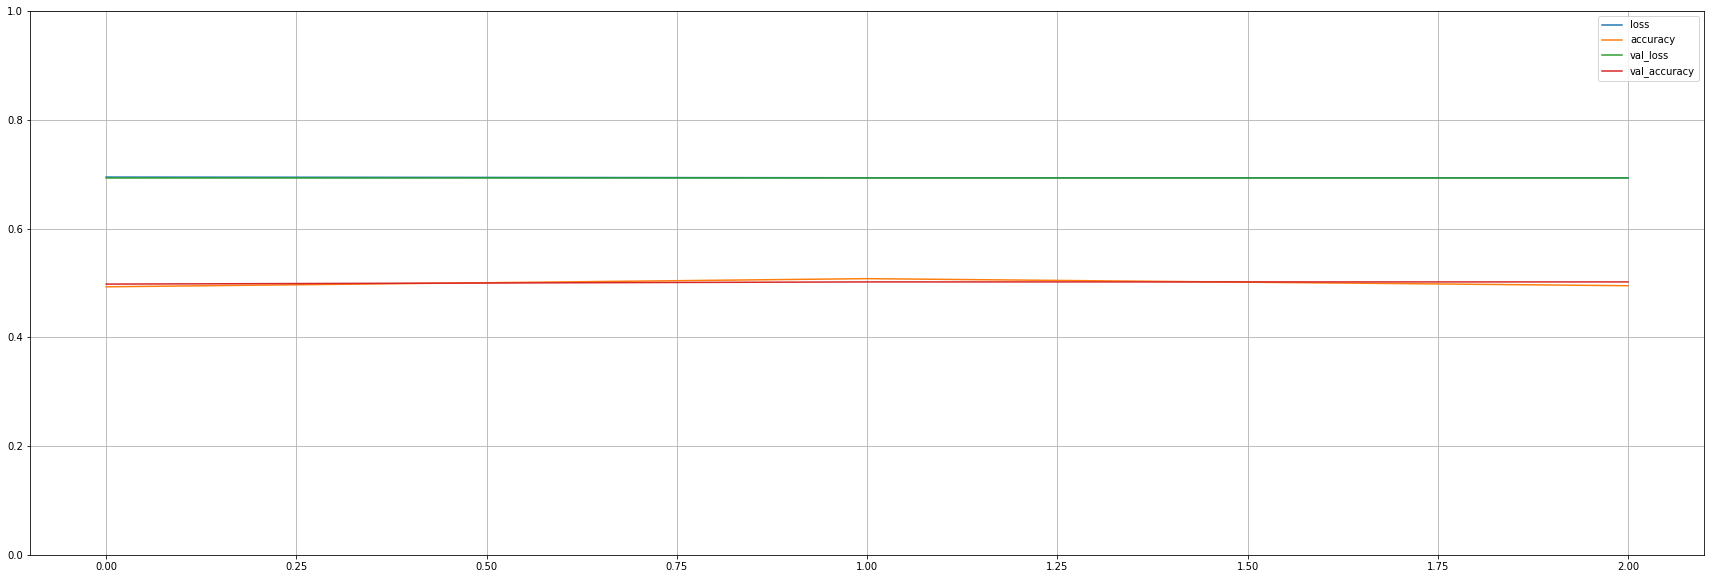

In [60]:
pd.DataFrame(history.history).plot(figsize=(30,10))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()